In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
import json
from albumentations import Compose, Normalize
from albumentations.pytorch.transforms import ToTensorV2
import pandas as pd
import os
import os.path as osp
import gc
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.nn.init as init
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_NAME = 'ptfull_24_6_classes'

In [ ]:
!unzip '/content/drive/MyDrive/ecgtrain/downsample_custom_cut_24_6_classes_8_2_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: downsample_24_train_data/PAB/217-63425.png  
  inflating: downsample_24_train_data/PAB/107-40273.png  
  inflating: downsample_24_train_data/PAB/217-44517.png  
  inflating: downsample_24_train_data/PAB/217-61907.png  
  inflating: downsample_24_train_data/PAB/217-21052.png  
  inflating: downsample_24_train_data/PAB/107-47181.png  
  inflating: downsample_24_train_data/PAB/217-4370.png  
  inflating: downsample_24_train_data/PAB/217-28419.png  
  inflating: downsample_24_train_data/PAB/107-3269.png  
  inflating: downsample_24_train_data/PAB/107-59385.png  
  inflating: downsample_24_train_data/PAB/217-472.png  
  inflating: downsample_24_train_data/PAB/107-51555.png  
  inflating: downsample_24_train_data/PAB/217-61264.png  
  inflating: downsample_24_train_data/PAB/217-655.png  
  inflating: downsample_24_train_data/PAB/217-1580.png  
  inflating: downsample_24_train_data/PAB/107-35219.png  
  inflating: downsample_24_t

In [ ]:
class HeartNet(nn.Module):
    def __init__(self, num_classes=8):
        super(HeartNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64, eps=0.001),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64, eps=0.001),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(128, eps=0.001),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(128, eps=0.001),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(256, eps=0.001),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(256, eps=0.001),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 16 * 256, 2048),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(2048, eps=0.001),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
class Ecg2DDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
    def __getitem__(self, index):
        img_path = self.df.loc[index, 'path']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # mean = 244.4575
        # std = 39.1584
        # img = (img - mean) / std
        img = img/255.0
        img = img.reshape(1, 128, 128)
        return torch.Tensor(img).float(), int(self.df.loc[index, 'label'])
    def get_dataloader(self, pin_memory, num_workers=4, batch_size=16, shuffle=True, ):
        data_loader = DataLoader(
            self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory = pin_memory
        )
        return data_loader
  
    def __len__(self):
        return len(self.df)

In [ ]:
# Load data from CSV files
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}
train_data = train_data.replace({'label': label_mapping})
val_data = val_data.replace({'label': label_mapping})
test_data = test_data.replace({'label': label_mapping})

In [ ]:
DATA_PATH = 'custom_cut_data'
train_loader = Ecg2DDataset(
    train_data
).get_dataloader(
    batch_size=128,
    num_workers=os.cpu_count(),
    pin_memory=True
)
val_loader = Ecg2DDataset(
    val_data
).get_dataloader(
    batch_size=128,
    num_workers=os.cpu_count(),
    pin_memory=True,
    shuffle=False
)
test_loader = Ecg2DDataset(
    test_data
).get_dataloader(
    batch_size=128,
    num_workers=os.cpu_count(),
    pin_memory=True,
    shuffle=False
)

In [ ]:
def load_checkpoint(path, model, optimizer=None):
    pth = torch.load(path)

    model.load_state_dict(pth['state_dict'])
    if optimizer:
        optimizer.load_state_dict(pth['optimizer'])

    print("Checkpoint {} successfully loaded".format(path))

    return pth['epoch'], pth['total_iter']


def save_checkpoint(state, path):
    torch.save(state, path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

heartnet = HeartNet(num_classes=6).to(device)


In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)  # Using Xavier uniform initialization
        if m.bias is not None:
            init.constant_(m.bias.data, 0.0)  # Initialize biases to zero

heartnet.apply(initialize_weights)

optimizer = torch.optim.Adam(heartnet.parameters(), lr=1e-3)
critetion = nn.CrossEntropyLoss().to(device)

In [ ]:
ECG_DIR = '/content/drive/MyDrive/ecgtrain'

In [ ]:
# LOG_DIR = '/content/drive/MyDrive/ecgtrain/heartnet/logs'
LOG_DIR = osp.join(ECG_DIR, MODEL_NAME, 'logs')
# PTH_DIR = '/content/drive/MyDrive/ecgtrain/heartnet/checkpoints'
PTH_DIR = osp.join(ECG_DIR, MODEL_NAME, 'checkpoints')
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
if not os.path.exists(PTH_DIR):
    os.makedirs(PTH_DIR)
writer = SummaryWriter(log_dir=LOG_DIR)

In [ ]:
history_df = {}
history_df['loss']=[]
history_df['val_loss']=[]
history_df['accuracy']=[]
history_df['val_accuracy']=[]

In [ ]:
total_iter = 0
training_epoch = 0
epochs = 10

def train_one_epoch(total_iter):
    heartnet.train()
    total_loss = 0

    gt_class = np.empty(0)
    pd_class = np.empty(0)
    for i, data in enumerate(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        predictions: torch.Tensor = heartnet(inputs)
        loss = critetion(predictions, targets)
        
        classes = predictions.argmax(dim=1).reshape(-1).cpu().numpy()
        
        gt_class = np.concatenate((gt_class, data[1].numpy()))
        pd_class = np.concatenate((pd_class, classes))

        class_accuracy = sum(pd_class == gt_class) / pd_class.shape[0]
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            print("\tIter [%d/%d] Loss: %.4f" % (i + 1, len(train_loader), loss.item()))
            print("\tIter [%d/%d] acc: %.4f" % (i + 1, len(train_loader), class_accuracy))
            
        if (total_iter + 1) % 1000 == 0:
            for g in optimizer.param_groups:
                lr = g['lr']
                g['lr'] *= 0.95
                
        writer.add_scalar("Train loss (iterations)", loss.item(), total_iter)
        total_iter += 1
        
    total_loss /= len(train_loader)
    class_accuracy = sum(pd_class == gt_class) / pd_class.shape[0] 
    
    print('Train loss - {:4f}'.format(total_loss))
    print('Train CLASS accuracy - {:4f}'.format(class_accuracy))

    writer.add_scalar('Train loss (epochs)', total_loss, training_epoch)
    history_df['loss'].append(total_loss)
    writer.add_scalar('Train CLASS accuracy', class_accuracy, training_epoch)
    history_df['accuracy'].append(class_accuracy)

def val():
    heartnet.eval()
    total_loss = 0

    gt_class = np.empty(0)
    pd_class = np.empty(0)
    
    with torch.no_grad():
        
        for i, data in tqdm(enumerate(val_loader)):
            inputs, targets = data[0].cuda(), data[1].cuda()
            
            predictions: torch.Tensor = heartnet(inputs)
            loss = critetion(predictions, targets)
            
            classes = predictions.argmax(dim=1).reshape(-1).cpu().numpy()
            
            gt_class = np.concatenate((gt_class, data[1].numpy()))
            pd_class = np.concatenate((pd_class, classes))

            total_loss += loss.item()
        
    total_loss /= len(val_loader)
    class_accuracy = sum(pd_class == gt_class) / pd_class.shape[0] 
    
    print('Validation loss - {:4f}'.format(total_loss))
    print('Validation CLASS accuracy - {:4f}'.format(class_accuracy))

    writer.add_scalar('Validation loss', total_loss, training_epoch)
    history_df['val_loss'].append(total_loss)
    writer.add_scalar('Validation CLASS accuracy', class_accuracy, training_epoch)
    history_df['val_accuracy'].append(class_accuracy)
    
def loop(training_epoch, epochs):
    
    for epoch in range(training_epoch, epochs):
        print(f"Epoch - {training_epoch}")
        train_one_epoch(total_iter)
        save_checkpoint({
            'state_dict': heartnet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'total_iter': total_iter
        }, os.path.join(PTH_DIR, f"{epoch}.pth"))
        val()
        
        training_epoch += 1
        # history_df.to_json(osp.join(ECG_DIR, MODEL_NAME, 'hist.json'), orient='record')
        json.dump(history_df, open(os.path.join(ECG_DIR, MODEL_NAME, 'hist.json'), 'w'))
    print(training_epoch)


In [ ]:
epochs, training_epoch

(10, 0)

In [ ]:
def free_cuda_mem():
  gc.collect()
  torch.cuda.empty_cache() 

In [ ]:
loop(training_epoch, epochs)

In [ ]:
val()

137it [00:21,  6.29it/s]

Validation loss - 0.246032
Validation CLASS accuracy - 0.944429


In [ ]:
hist_df = json.load(open(osp.join(ECG_DIR, MODEL_NAME, 'hist.json'), 'r'))

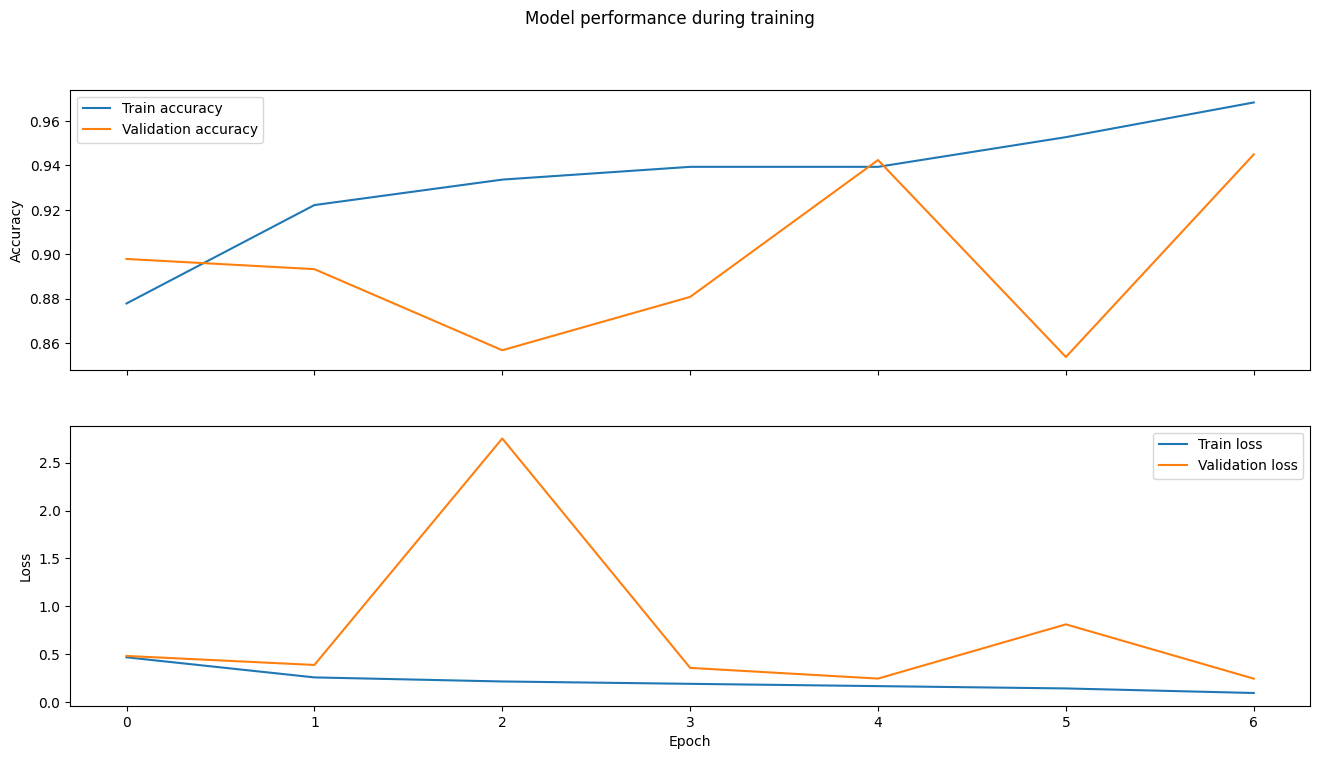

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
axes[0].plot(hist_df['accuracy'])
axes[0].plot(hist_df['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[1].plot(hist_df['loss'])
axes[1].plot(hist_df['val_loss'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
fig.suptitle('Model performance during training')
axes[0].legend(('Train accuracy', 'Validation accuracy'))
axes[1].legend(('Train loss', 'Validation loss'))

In [ ]:
load_checkpoint(os.path.join(PTH_DIR, f"curr.pth"), heartnet)

Checkpoint /content/drive/MyDrive/ecgtrain/ptfull_24_6_classes/checkpoints/curr.pth successfully loaded


(99, 0)

In [ ]:
gt_class = np.empty(0)
pd_class = np.empty(0)
heartnet.eval()
for i, data in tqdm(enumerate(test_loader)):
    inputs, targets = data[0].cuda(), data[1].cuda()
    
    predictions: torch.Tensor = heartnet(inputs)    
    classes = predictions.argmax(dim=1).reshape(-1).cpu().numpy()
    
    gt_class = np.concatenate((gt_class, data[1].numpy()))
    pd_class = np.concatenate((pd_class, classes))

class_accuracy = sum(pd_class == gt_class) / pd_class.shape[0] 


30it [00:11,  2.65it/s]


In [ ]:
class_accuracy

0.6807549175970229

[[2125   50    0   13    3    3]
 [  39    5    2    0    0    6]
 [   0    0  405    0    0    0]
 [ 401   63    0   25    0   10]
 [ 168  365   18    0    0    0]
 [  53    3    0    4    0    1]]


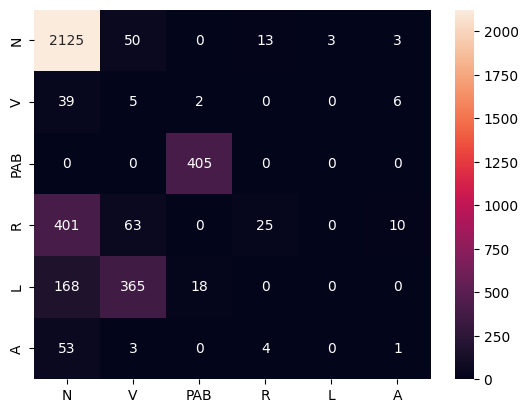

In [ ]:
cm = confusion_matrix(gt_class, pd_class)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), fmt="d")
plt.show()



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gt_class, pd_class))

              precision    recall  f1-score   support

         0.0       0.76      0.97      0.85      2194
         1.0       0.01      0.10      0.02        52
         2.0       0.95      1.00      0.98       405
         3.0       0.60      0.05      0.09       499
         4.0       0.00      0.00      0.00       551
         5.0       0.05      0.02      0.02        61

    accuracy                           0.68      3762
   macro avg       0.40      0.36      0.33      3762
weighted avg       0.63      0.68      0.62      3762



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(gt_class, pd_class, average='macro')

(0.39520160339918164, 0.3551996802837778, 0.327502904911714, None)